In [2]:
import nibabel as nib
import numpy as np
import pandas as pd
import scipy 
import numpy.matlib
import seaborn as sns

In [3]:
from sklearn import linear_model 
from sklearn import model_selection
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [4]:
motor_value_mat = pd.read_csv('https://raw.githubusercontent.com/asafmm/inconsistency_functional_connectivity/main/fc_matrices.csv', index_col = 'Subject')

In [6]:
schaefer_mat = pd.read_csv('https://raw.githubusercontent.com/asafmm/inconsistency_functional_connectivity/main/schaefer_fc_matrix.csv', index_col = 'Subject')

In [7]:
incon = pd.read_csv('https://raw.githubusercontent.com/asafmm/inconsistency_functional_connectivity/main/aggregate_indices_subs101_148_08Dec2020.csv', index_col = 'Subject')

In [8]:
X = motor_value_mat

In [273]:
Ys = incon.loc[motor_value_mat.index]

In [10]:
all_measures = ['GARP Violations', 'AFRIAT Index', 'VARIAN Index AVG(SSQ)', 'Houtman Maks Index', 'MMI Criterion Avg(SumOfSquares(Wastes))']

In [12]:
inconsistent_subjects = Ys.loc[:, 'GARP Violations']!=0

In [13]:
Ys_incon = Ys.loc[inconsistent_subjects, :]
X_incon = X.loc[inconsistent_subjects, :]

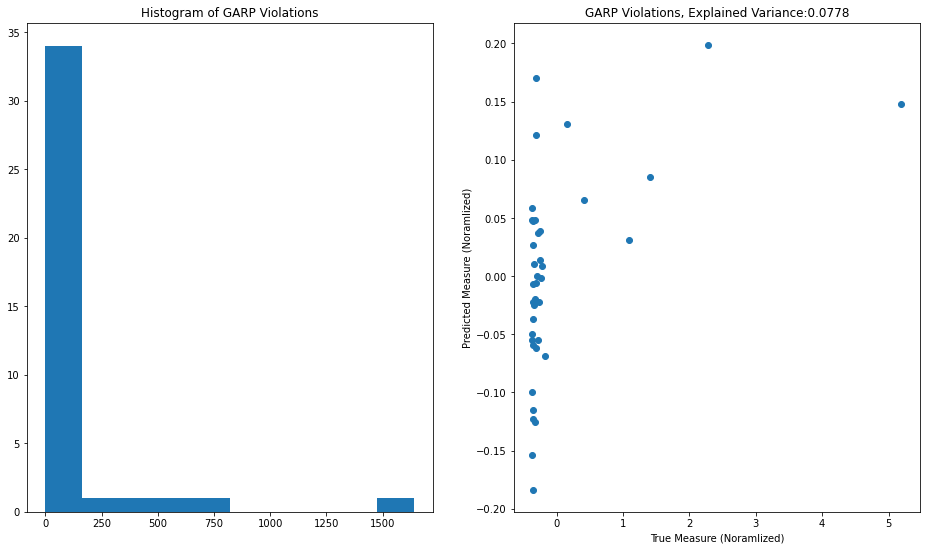

KeyboardInterrupt: 

In [270]:
for measure in all_measures:
    y = Ys.loc[:, measure]
 
    #    X_scaled = (X - np.mean(X))/np.std(X)
    X_scaled = (X.transpose() - np.mean(X, axis=1))/np.std(X, axis=1)
    X_scaled = X_scaled.transpose()
    y_scaled = (y - np.mean(y))/np.std(y)
 
    lin_model = linear_model.ElasticNetCV(l1_ratio = np.arange(0.1, 1, 0.1),cv = len(X_incon), max_iter=50000)
    lin_model.fit(X_scaled, y_scaled)
    y_pred = lin_model.predict(X_scaled)
 

    # print(f'Explained Variance for {measure}: {metrics.explained_variance_score(y_scaled, y_pred):.4f} \n' )
    _ = plt.figure(figsize = (16,9))
    _ = plt.subplot(121)
    _ = plt.title(f'Histogram of {measure}')
    _ = plt.hist(Ys.loc[:, measure])
    _ = plt.subplot(122)
    _ = plt.scatter(y_scaled, y_pred)
    _ = plt.ylabel('Predicted Measure (Noramlized)')
    _ = plt.xlabel('True Measure (Noramlized)')
    plt.title(measure + ', Explained Variance:' + format(metrics.explained_variance_score(y_scaled, y_pred), '.4f'))
    plt.show()

In [14]:
def select_features(X, y, pval_thresh, number_thresh = 0):
    if number_thresh != 0:
        column_len = len(X.columns)
        y_mat = np.matlib.repmat(y, column_len, 1)
        x_y_corr = np.corrcoef(X.transpose(), y_mat)
        abs_corr = np.abs(x_y_corr)
        top_indices = np.argsort(abs_corr[column_len, 0:column_len])
        top_features = X.columns[top_indices[-1 * number_thresh:]]
        return top_features
    else:
        selected_features = []
        corrs = []
        for feature in X.columns:
            feature_data = X.loc[:, feature]
            r, pval = scipy.stats.pearsonr(feature_data, y)
            if pval < pval_thresh:
                selected_features.append(feature)
                corrs.append(r)
        return selected_features

In [15]:
# log transform + consistent subject removed
def get_coefs(X, y, measure, model_type, feature_number):
    
    models = []
    scores = []
    y = np.log(y.loc[:, measure])
    measure_text = measure.split(sep=' ')[0]
    
    if model_type == 'Elastic':
        lin_model = linear_model.ElasticNetCV(l1_ratio = np.arange(0.01, 1, 0.02), cv = 5, alphas = np.arange(0.01, 1, 0.01), max_iter=50000, n_jobs = -1)
    elif model_type == 'Ridge': 
        lin_model = linear_model.RidgeCV(alphas = np.arange(0.01, 5, 0.01), cv = 5)
    elif model_type == 'Lasso': 
        lin_model = linear_model.LassoCV(alphas = np.arange(0.01, 5, 0.01), cv = 5, max_iter = 50000, n_jobs = -1)
    elif model_type == 'Linear':
        lin_model = linear_model.LinearRegression(n_jobs = -1)

    loo = model_selection.LeaveOneOut()
    i = 1
    y_hats = []
    y_true = []
    coefs_list = []
    for train_ind, test_ind in loo.split(X):
        X_train, X_test = X.iloc[train_ind, :], X.iloc[test_ind, :]
        y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]
        # selected top N features with highest correlation with y_train
        selected_features = select_features(X_train, y_train, 0.05, feature_number)
        X_train, X_test = X_train.loc[:, selected_features], X_test.loc[:, selected_features]

        # scaling X by subject
        X_train = (X_train.transpose() - np.mean(X_train, axis=1)) / np.std(X_train, axis=1)
        X_train = X_train.transpose()
        # scaling by subject therefore 
        X_test = (X_test.transpose() - np.mean(X_test, axis=1)) / np.std(X_test, axis=1)
        X_test = X_test.transpose()
        # scale X by feature
        # X_train = (X_train - np.mean(X_train)) / np.std(X_train)
        # X_test = (X_test - np.mean(X_train)) / np.std(X_train)
        # scale y_train
        y_train = (y_train - np.mean(y_train)) / np.std(y_train)
        # scale y_test with *y_train*
        y_test = (y_test - np.mean(y_train)) / np.std(y_train)
        
        lin_model.fit(X_train, y_train)
        
        features = X_train.columns
        features = features.append(pd.Index(['Score']))
        coef_df = pd.DataFrame(features)
        
        y_pred = lin_model.predict(X_test)
        models.append(lin_model)
        score = metrics.mean_squared_error(y_test, y_pred)
        y_hats.append(y_pred[0])
        y_true.append(y_test.values[0])
        
        coefs = lin_model.coef_
        coef_df[measure_text + str(i)] = np.append(coefs, score)
        coefs_list.append(coef_df)
        i += 1
    return coefs_list, y_hats, y_true, models

In [267]:
def print_results(y_true, y_hats, measure, model):
    measure_text = measure.split(sep=' ')[0]
    r, pval = scipy.stats.pearsonr(y_true, y_hats)
    print('r: {:.4f}'.format(r), '\np-val: {:.4f}'.format(pval))
    fig = plt.figure(figsize = (8, 5))
    ax = fig.add_subplot()
    plt.scatter(y_true, y_hats)
    plt.title(measure_text + ' ' + model + ' Model')
    plt.xlabel('True Measure')
    plt.ylabel('Predicted Measure')
    plt.text(0.8, 0.03, 'r = {:.4f}'.format(r) + '\np-val = {:.4f}'.format(pval), transform = ax.transAxes)
    slope, intercept = np.polyfit(y_true, y_hats, 1)
    _ = plt.plot(y_true, np.multiply(y_true, slope) + intercept)
    return r, pval

r: 0.2789 
p-val: 0.1160


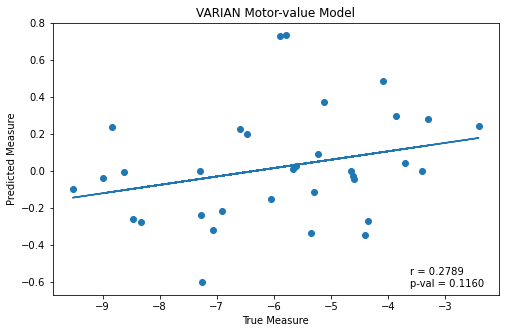

In [277]:
# Motor-value matrix
coef_df_value_motor, y_hats, y_true, models = get_coefs(motor_value_mat.loc[inconsistent_subjects, :], Ys_incon, all_measures[2], 'Lasso', 30)
r, pval = print_results(y_true, y_hats, all_measures[2], 'Motor-value')

In [22]:
for i in range(33):
    coef_df = coef_df_value_motor[i]
    print(coef_df.loc[coef_df.loc[:, 'VARIAN' + str(i+1)]!=0, [0, 'VARIAN' + str(i+1)]].sort_values(by = 'VARIAN' + str(i+1)))

                 0    VARIAN1
16  preSMA_L_VMPFC  -0.151601
24   preSMA_R_M1_R  -0.140543
27     SMA_R_VMPFC   0.744009
28           Score  25.064329
                 0    VARIAN2
24   preSMA_R_M1_R  -0.135476
17  preSMA_L_VMPFC  -0.075915
26      M1_R_VMPFC   0.001560
27     SMA_R_VMPFC   0.851762
28           Score  16.633130
                 0    VARIAN3
24   preSMA_R_M1_R  -0.201671
18  preSMA_L_VMPFC  -0.159835
27     SMA_R_VMPFC   0.711373
28           Score  45.540392
        0    VARIAN4
28  Score  11.526219
              0    VARIAN5
27  SMA_R_VMPFC   0.095053
28        Score  88.822271
                 0    VARIAN6
24   preSMA_R_M1_R  -0.189640
16  preSMA_L_VMPFC  -0.161068
22  preSMA_R_SMA_L  -0.016256
26      M1_R_VMPFC   0.043769
27     SMA_R_VMPFC   0.716400
28           Score  20.755479
                 0    VARIAN7
19  preSMA_L_VMPFC  -0.161783
24   preSMA_R_M1_R  -0.124357
23   preSMA_L_M1_L  -0.023747
27     SMA_R_VMPFC   0.786646
28           Score  16.468937
       

r: 0.3556 
p-val: 0.0423


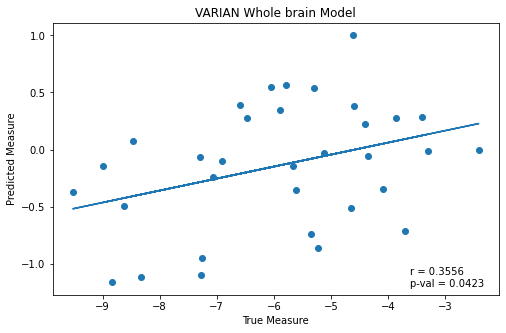

In [280]:
# Schaefer matrix
coef_df_schaefer, y_hats, y_true, models = get_coefs(schaefer_mat.loc[inconsistent_subjects, :], Ys_incon, all_measures[2], 'Lasso', 45)
r, pval = print_results(y_true, y_hats, all_measures[2], 'Whole brain')

In [278]:
models_features = []
for i in range(0, 33):
    coef_df = coef_df_value_motor[i]
    current_features = list(coef_df.loc[coef_df.loc[:, 'VARIAN' + str(i+1)]!=0, 0].values)
    [models_features.append(val) for val in current_features]
models_features = pd.DataFrame(models_features)
models_features.value_counts()[1:15]

SMA_R_VMPFC       32
preSMA_R_M1_R     31
preSMA_L_VMPFC    30
M1_R_VMPFC        11
preSMA_L_M1_L      8
preSMA_R_SMA_L     5
dtype: int64

In [279]:
models_features

,0
0,preSMA_L_VMPFC
1,preSMA_R_M1_R
2,SMA_R_VMPFC
3,Score
4,preSMA_L_VMPFC
...,...
145,preSMA_L_VMPFC
146,preSMA_R_M1_R
147,M1_R_VMPFC
148,SMA_R_VMPFC


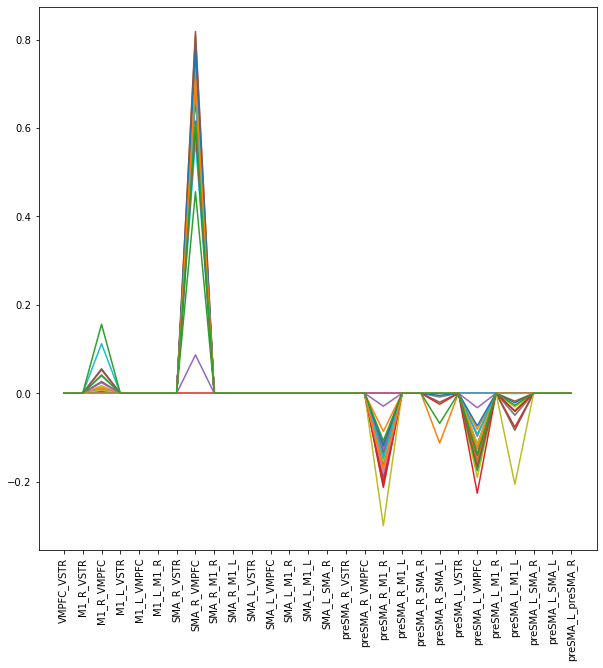

In [20]:
plt.figure(figsize=(10,10))
for i in range(1, coef_df_value_motor.shape[1]):
    plt.plot(coef_df_value_motor.iloc[:-1, 0], coef_df_value_motor.iloc[:-1, i])
    _ = plt.xticks(rotation=90)

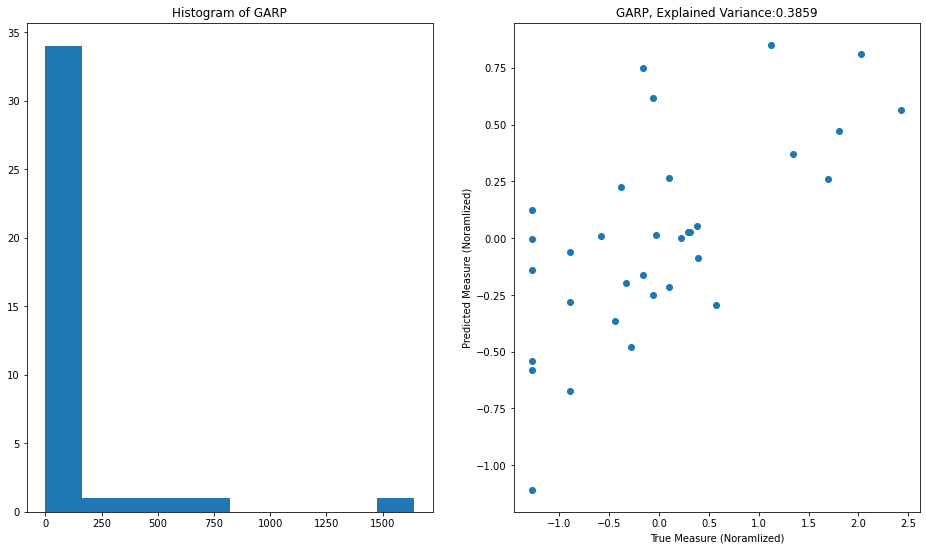

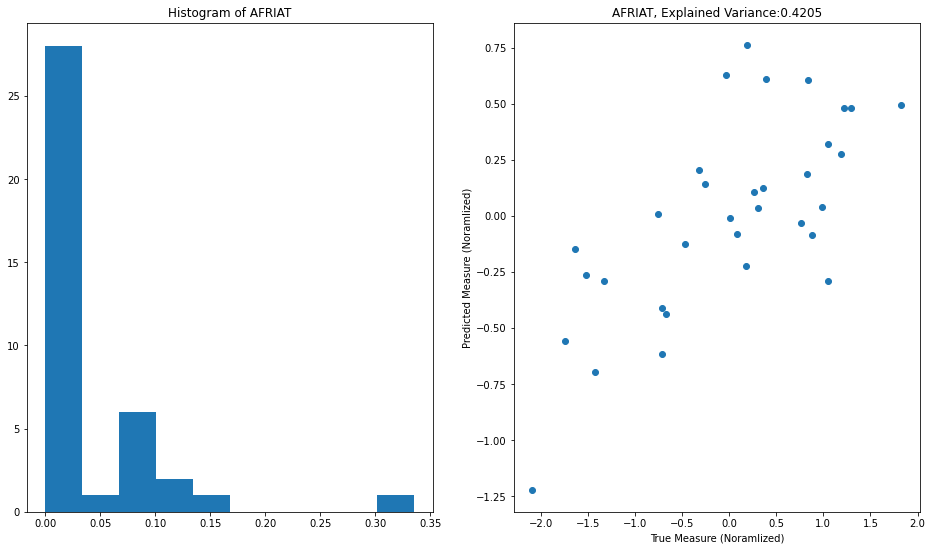

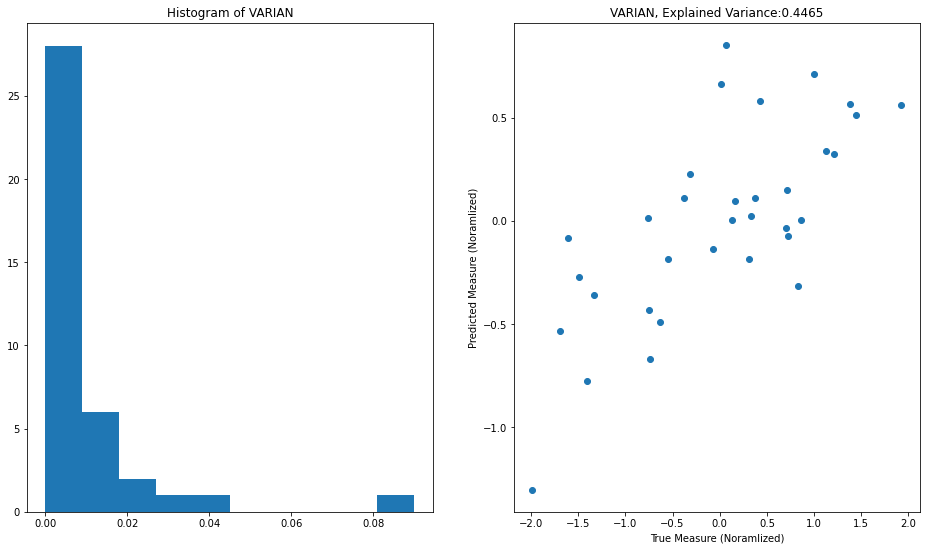

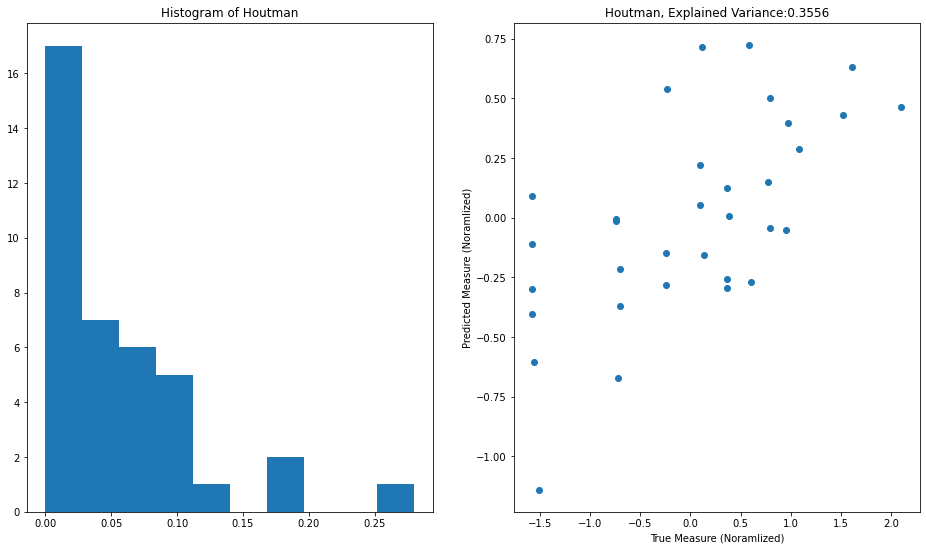

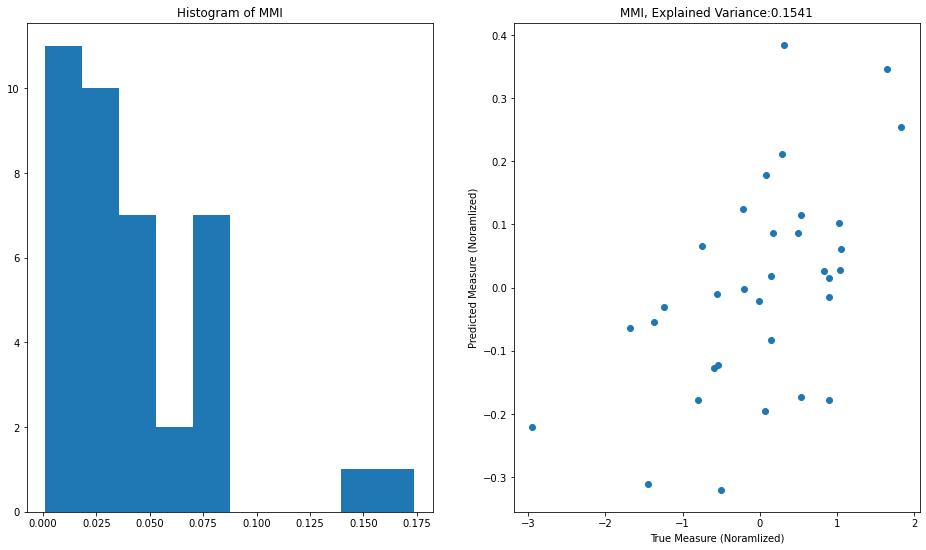

In [11]:
# log transform + consistent subject removed
features = X.columns
coef_df = pd.DataFrame(features)
for measure in all_measures:
    y = np.log(Ys_incon.loc[:, measure])

    measure_text = measure.split(sep=' ')[0]
    # scale by feature
    #X_scaled = (X_incon - np.mean(X_incon))/np.std(X_incon)
    # scale by subject
    X_scaled = (X_incon.transpose() - np.mean(X_incon, axis=1))/np.std(X_incon, axis=1)
    X_scaled = X_scaled.transpose()
    
    y_scaled = (y - np.mean(y))/np.std(y)
    
    lin_model = linear_model.ElasticNetCV(l1_ratio = np.arange(0.1, 1, 0.1),cv = len(X_incon), max_iter=50000)
    lin_model.fit(X_scaled, y_scaled)
    y_pred = lin_model.predict(X_scaled)
 
    _ = plt.figure(figsize = (16,9))
    _ = plt.subplot(121)
    _ = plt.title(f'Histogram of {measure_text}')
    _ = plt.hist(Ys.loc[:, measure])
    _ = plt.subplot(122)
    _ = plt.scatter(y_scaled, y_pred)
    _ = plt.ylabel('Predicted Measure (Noramlized)')
    _ = plt.xlabel('True Measure (Noramlized)')
    plt.title(measure_text + ', Explained Variance:' + format(metrics.explained_variance_score(y_scaled, y_pred), '.4f'))
    plt.show()

    coef_df[measure_text + ' Model'] = lin_model.coef_

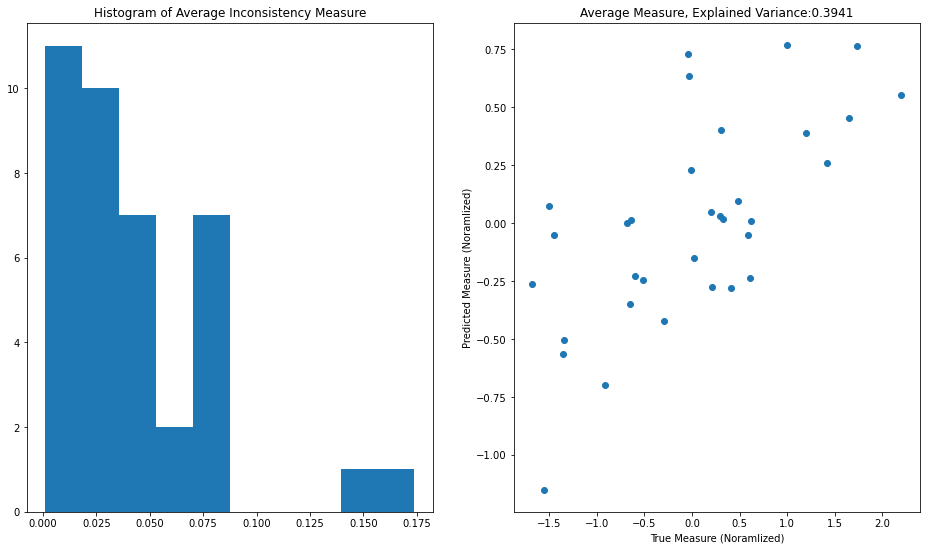

,0,WARP Model,GARP Model,SARP Model,AFRIAT Model,VARIAN Model,Houtman Model,MMI Model
0,VMPFC_VSTR,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,M1_R_VSTR,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000
2,M1_R_VMPFC,0.000000,0.000000,0.006627,0.031632,0.022960,0.000000,0.000000
3,M1_L_VSTR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,M1_L_VMPFC,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000
5,M1_L_M1_R,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,SMA_R_VSTR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,SMA_R_VMPFC,0.843396,0.866260,0.816121,0.683662,0.757382,0.739853,0.845909
8,SMA_R_M1_R,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000
9,SMA_R_M1_L,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000


In [66]:
# Average measure
avg_measure = np.mean(np.log(Ys_incon.loc[:, all_measures]), 1)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X_incon, avg_measure, test_size = 0.2, random_state=42)

X_scaled = (X_incon.transpose() - np.mean(X_incon, axis=1))/np.std(X_incon, axis=1)
X_scaled = X_scaled.transpose()
y_scaled = (avg_measure - np.mean(avg_measure))/np.std(avg_measure)

lin_model = linear_model.ElasticNetCV(l1_ratio = np.arange(0.1, 1, 0.1),cv = len(X_incon), max_iter=50000)
lin_model.fit(X_scaled, y_scaled)
y_pred = lin_model.predict(X_scaled)

_ = plt.figure(figsize = (16,9))
_ = plt.subplot(121)
_ = plt.title(f'Histogram of Average Inconsistency Measure')
_ = plt.hist(Ys.loc[:, measure])
_ = plt.subplot(122)
_ = plt.scatter(y_scaled, y_pred)
_ = plt.ylabel('Predicted Measure (Noramlized)')
_ = plt.xlabel('True Measure (Noramlized)')
plt.title('Average Measure, Explained Variance:' + format(metrics.explained_variance_score(y_scaled, y_pred), '.4f'))
plt.show()

coef_df[measure_text + ' Model'] = lin_model.coef_
coef_df

In [41]:
Ys_incon.loc[:, all_measures].corr()

,GARP Violations,AFRIAT Index,VARIAN Index AVG(SSQ),Houtman Maks Index,MMI Criterion Avg(SumOfSquares(Wastes))
GARP Violations,1.000000,0.921882,0.971813,0.884880,0.806522
AFRIAT Index,0.921882,1.000000,0.981271,0.906334,0.837215
VARIAN Index AVG(SSQ),0.971813,0.981271,1.000000,0.912798,0.825225
Houtman Maks Index,0.884880,0.906334,0.912798,1.000000,0.892553
MMI Criterion Avg(SumOfSquares(Wastes)),0.806522,0.837215,0.825225,0.892553,1.000000


In [12]:
# transform measures to ordinary scale and correlate fc_matrix to ordinary scale

# predict task fmri form rest ??? - Consult with Ido

# choose control ROIs - V1, ?

# Correlation matrix for Inocnsistency measures

# Draugowitz - 3 sources for inconsistency

# Emily Finn - take only top correlations with the y

# Stepwise regression